In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import tensorflow_datasets as tfds 
tfds.load("div2k/bicubic_x4")

{'train': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>,
 'validation': <PrefetchDataset shapes: {hr: (None, None, 3), lr: (None, None, 3)}, types: {hr: tf.uint8, lr: tf.uint8}>}

In [140]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

In [141]:
from skimage import data
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [142]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr


In [14]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

3개 이미지(bicubic interpolation의 결과, SRCNN의 결과, 원래 고해상도 이미지)를 나란히 시각화

In [16]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch


✅


In [17]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


In [18]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


In [19]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


In [20]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[1] - STEP[10] 
Generator_loss:0.0015 
Discriminator_loss:1.3457

EPOCH[1] - STEP[20] 
Generator_loss:0.0020 
Discriminator_loss:0.8231

EPOCH[1] - STEP[30] 
Generator_loss:0.0019 
Discriminator_loss:0.8944

EPOCH[1] - STEP[40] 
Generator_loss:0.0018 
Discriminator_loss:0.9489

EPOCH[1] - STEP[50] 
Generator_loss:0.0018 
Discriminator_loss:0.9817

EPOCH[1] - STEP[60] 
Generator_loss:0.0018 
Discriminator_loss:0.8982

EPOCH[1] - STEP[70] 
Generator_loss:0.0021 
Discriminator_loss:0.7955

EPOCH[1] - STEP[80] 
Generator_loss:0.0024 
Discriminator_loss:0.7006

EPOCH[1] - STEP[90] 
Generator_loss:0.0027 
Discriminator_loss:0.6270

EPOCH[1] - STEP[100] 
Generator_loss:0.0030 
Discriminator_loss:0.5677

EPOCH[1] - STEP[110] 
Generator_loss:0.0032 
Discriminator_loss:0.5176

EPOCH[1] - STEP[120] 
Generator_loss:0.0035 
Discriminator_loss:0.4764

EPOCH[1] - STEP[130] 
Generator_loss:0.0037 
Discriminator_loss:0.4464

EPOCH[1] - STEP[140] 
Generator_loss:0.0038 
Discriminator_loss:0.4220

E

In [143]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

In [144]:
import cv2

# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def interpolation_xn(image, n):
    downsample = cv2.resize(
        image,
        dsize=(hr_shape[1]//n, hr_shape[0]//n)
    )
    upsample = cv2.resize(
        downsample,
        dsize=(hr_shape[1], hr_shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample


## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
이제 여러분이 직접 다른 이미지를 사용해 볼 차례입니다.

앞서 사용했던 DIV2K 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. (모델 학습을 진행하는 건 아닙니다❗) 테스트할 이미지를 고를 때, DIV2K 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.

### 프로젝트 1-1.

1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 `apply_srgan` 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 `cv2.resize()`를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화 합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)



이미지 로드 및 np array화: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays 참고(asarray, PIL Image.open())

In [138]:
from PIL import Image
from numpy import asarray
import cv2

# 1
hr = Image.open('hubble3079.jpg')
hr = np.array(asarray(hr))
print(hr.shape)

# 2
lr = cv2.resize(
    hr, 
    dsize=(hr.shape[1]//4,hr.shape[0]//4)
)
print(lr.shape)


# 3
srgan_hr = apply_srgan(lr)

# 4
bicubic_img = cv2.resize(
    lr,
    (lr.shape[1]*4, lr.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)

imgs = [bicubic_img, srgan_hr, hr]
titles = ["Bicubic", "SRGAN", "HR"]

(1879, 3079, 3)
(469, 769, 3)


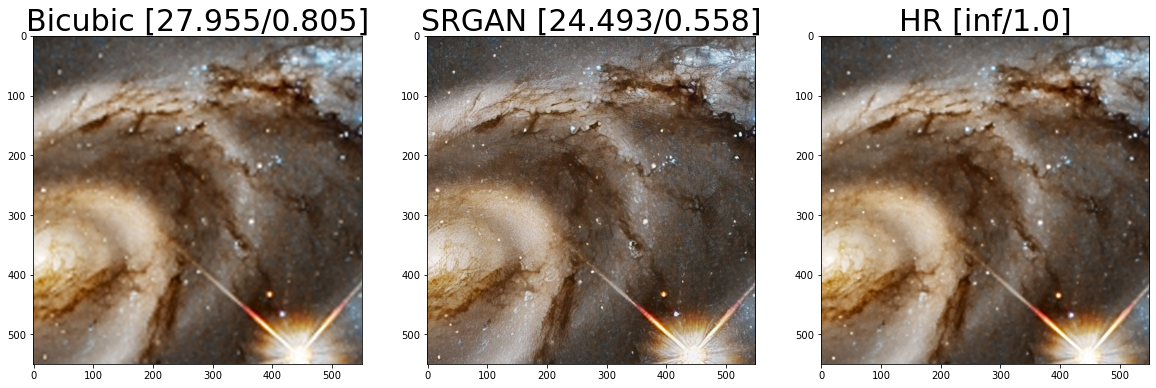

In [96]:
# 5. 시각화

# 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (750, 1150) 

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 550, 550) for i in imgs] 
titles = ["Bicubic", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(20,20)) # 이미지 크기를 조절할 수 있습니다.
for i in range(3):
    plt.subplot(1, 3, i+1)
    # crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
    plt.imshow(crop(imgs[i], left_top, 550, 550))
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

__천체사진이 아닌 다른 사진으로 한번 더 진행__

In [137]:
# 1
hr = Image.open('khalifa.jpg')
hr = np.array(asarray(hr))
print(hr.shape)

lr = cv2.resize(
    hr, 
    dsize=(hr.shape[1]//4,hr.shape[0]//4)
)

srgan_hr = apply_srgan(lr)
bicubic_img = cv2.resize(
    lr,
    (lr.shape[1]*4, lr.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)

imgs = [bicubic_img, srgan_hr, hr]
titles = ["Bicubic", "SRGAN", "HR"]

(1000, 1500, 3)


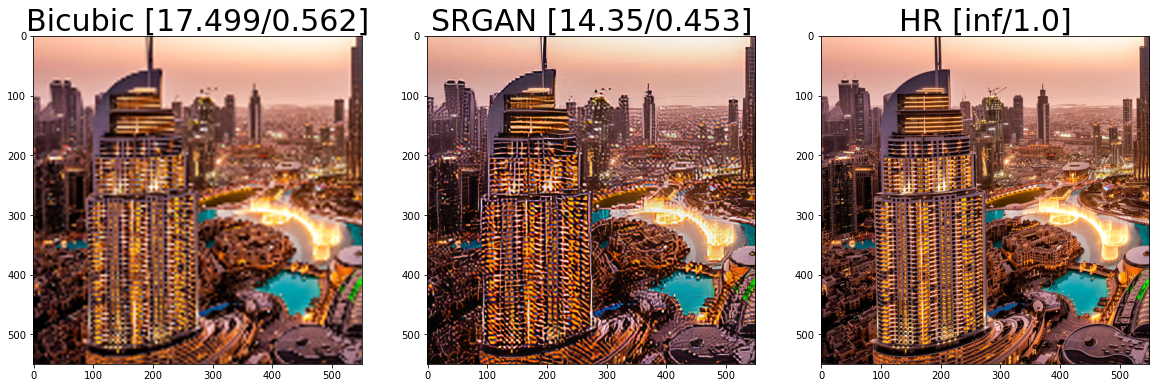

In [102]:
# 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (400, 200) 

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 450, 350) for i in imgs] 
titles = ["Bicubic", "SRGAN", "HR"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 3) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 3) for i in crop_images]

plt.figure(figsize=(20,20)) # 이미지 크기를 조절할 수 있습니다.
for i in range(3):
    plt.subplot(1, 3, i+1)
    # crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
    plt.imshow(crop(imgs[i], left_top, 550, 550))
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

__6.__    
노드의 테스트 결과들과 마찬가지로 선명도 자체는 bicubic보다 우월하지만 더 낮은 psnr, ssim 수치를 보여준다.    
특이하게도 천체사진에 한해서인지 SRGAN이 생성하는 최종이미지가 원본 이미지보다 더욱 고화질처럼 보인다. div2k 학습 데이터셋에 천체사진 혹은 유사 사진들의 개수가 많아서일수도 있고, SRGAN 자체가 천체사진과 같은 이미지들에 더욱더 특화되어일수도 있을 것으로 보인다. 혹은 인풋 low resolution 이미지 자체의 크기가 영향을 미치는 것일 수도 있을 것 같다.

### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화 합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(300, 209, 3) (1200, 836, 3) (1200, 836, 3)


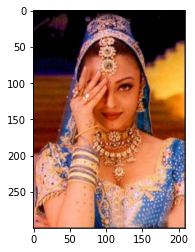

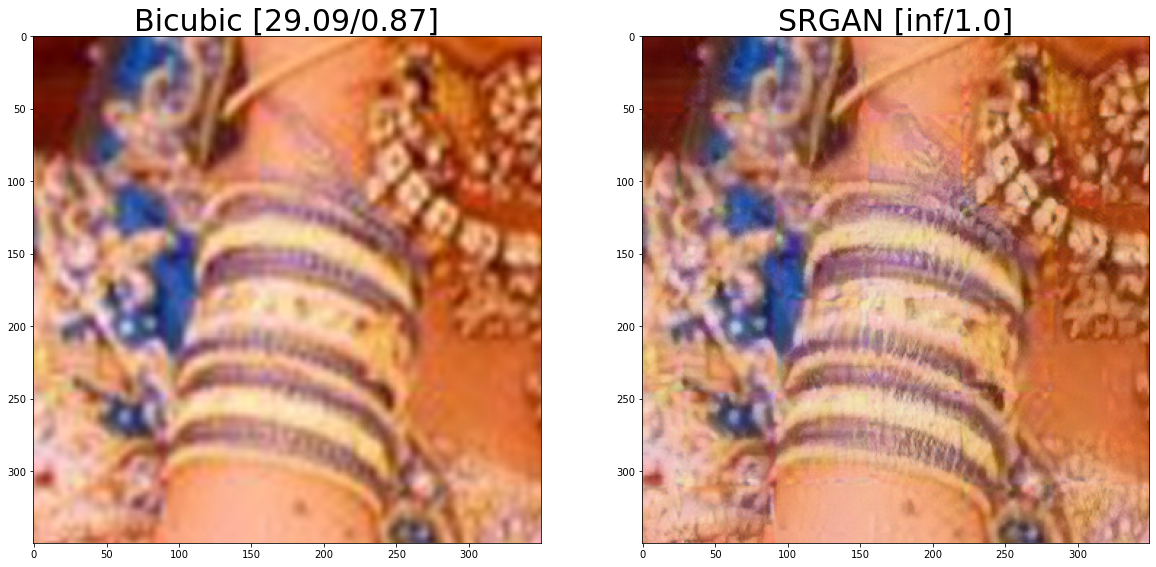

In [136]:
# 1
lr = Image.open('aish.jpg')
lr = np.array(asarray(lr))

plt.imshow(lr)

# 2
srgan_hr = apply_srgan(lr)

# 3
bicubic_hr = cv2.resize(
    lr,
    (lr.shape[1]*4, lr.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)
print(lr.shape, srgan_hr.shape, bicubic_hr.shape)


# 4
imgs = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

# 잘라낼 부분의 왼쪽 상단 좌표를 지정합니다.
left_top = (650, 100) 

# crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
crop_images = [crop(i, left_top, 250, 250) for i in imgs] 
titles = ["Bicubic", "SRGAN"]

psnr = [round(peak_signal_noise_ratio(crop_images[-1], i), 2) for i in crop_images]
ssim = [round(structural_similarity(crop_images[-1], i, multichannel=True), 2) for i in crop_images]

plt.figure(figsize=(20,20)) # 이미지 크기를 조절할 수 있습니다.
for i in range(2):
    plt.subplot(1, 2, i+1)
    # crop 함수 내의 세번째 네번째 인자를 수정해 이미지 크기를 조절합니다.
    plt.imshow(crop(imgs[i], left_top, 350, 350))
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=30)

__5.__    
SRGAN이 bicubic에 비해 부드럽게 연결되는 정도는 떨어질지라도 말단 디테일적인 부분에 대해서는 더욱 선명도가 높은 결과를 보여주고 있다. 팔찌의 개별 구분, 목걸이 및 화려한 장식들이 bicubic에 비해 더욱 세밀해보인다. 팔뚝에 찍은 점 두개도 비교적 진한 색으로 표현되어 있음을 볼 수 있다.    
원본 데이터와 동일한 확률분포를 갖는다는 GAN의 이론적인 특성과 최종 결과물 사이가 아직 확실하게 와닿지는 않지만, MSE loss를 적용하는지 여부에 따라 최종 결과물(특히 smoothness)이 달라지는 것 같다.